# PHYS 581 - Assignment 2
## Siegfried Peschke - 30032136
### February 2, 2021

In this assignment we utilize the TensorFlow package to investigate how a neural network goes about the task of determining slope and intercept from sets of data representing 2-D lines.

In [1]:
# Confirm virtual environment is active.
import sys
print(sys.executable)  # C:\Users\Sigi\anaconda3\envs\phys581\python.exe
assert( 'phys581' in sys.executable)

C:\Users\Sigi\anaconda3\envs\phys581\python.exe


In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

In [3]:
def generate_dataset_straightline(ncases=1000, domain=(-3,3), datapoints=5, paramlim=[(0,1),(0,1)]):
    """
    This function generates straight lines with slopes and intercepts within a specified range
    corresponding to a specified set of datapoints within a specified domain.
    """
    x = np.random.random( (ncases, datapoints) )*2*domain[1] + domain[0]
    nx = datapoints
    
    y = np.zeros( (ncases, nx) ) 
    
    params = np.random.random( (ncases,2) )
    for pindx in [0,1]:
        p = paramlim[pindx]
        p0 = p[0]
        dp = p[1] - p[0]
        params[:,pindx] = params[:,pindx]*dp + p0

    for indx in range(ncases):
        y[indx,0:nx] = x[indx,:]*params[indx,0] + params[indx,1]
    
    return y, x, params  

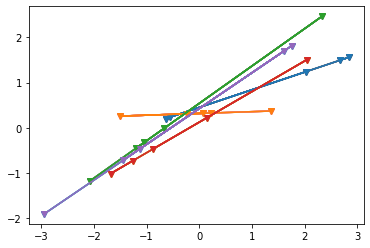

In [4]:
# Sample dataset, 5 lines with slopes & intercepts between 0 and 1 on the interval (-3,3)

datay, datax, params = generate_dataset_straightline(5)
for y in datay:
    plt.plot( datax.T, datay.T, 'v-' )

In [26]:
# Generate synthetic data set with known parameters (slope and intercept)
datay, datax, params = generate_dataset_straightline(9500)

ncases, nsteps = datay.shape

inputs = keras.Input( shape=( nsteps, ), name='input_y' )    

# Feed the result from one layer to the next ie.
# inputs -> dense1 -> dense2 -> outputs
xx = keras.layers.Dense(nsteps, input_dim=nsteps, activation='relu', name='dense1') (inputs)
xx = keras.layers.Dense(nsteps, input_dim=nsteps, activation='relu', name='dense2') (xx)

outputs = keras.layers.Dense(2, activation=None, name='output_slope_intercept')(xx)
model = keras.Model( inputs=inputs, outputs=outputs, name='Main' )
print(model.summary())

Model: "Main"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_y (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense1 (Dense)               (None, 5)                 30        
_________________________________________________________________
dense2 (Dense)               (None, 5)                 30        
_________________________________________________________________
output_slope_intercept (Dens (None, 2)                 12        
Total params: 72
Trainable params: 72
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
# Use the same topology but different initial conditions to train some more models.

models = [ model ]
results = [ result ]
for indx in range(5):
    models.append(  keras.models.clone_model( models[0] ) )
    models[-1].compile( optimizer='rmsprop', loss='mean_squared_error')
    results.append( models[-1].fit( datay, params, batch_size=64, epochs=80+80*(indx>=4), verbose=0, validation_split=0.3) )

Text(0.5, 0, 'epoch')

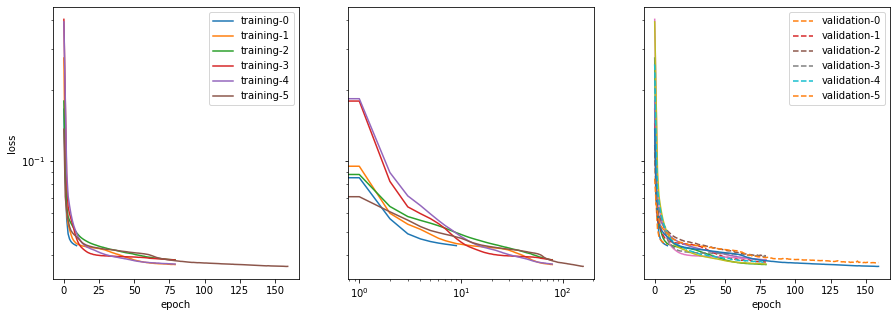

In [29]:
fig, axes = plt.subplots( 1, 3, figsize=(15,5), sharey=True )

plt.sca( axes[0] )
for indx,result in enumerate(results):
    plt.plot( result.history['loss'], label='training-'+str(indx) )
    
plt.legend(loc=0)
plt.yscale('log') #; plt.xscale('log')
plt.xlabel('epoch') ; plt.ylabel('loss')

plt.sca( axes[1] )
for indx,result in enumerate(results):
    plt.plot( result.history['loss'], label='training-'+str(indx) )
plt.xscale('log')
    
plt.sca( axes[2] )
for indx,result in enumerate(results):
    plt.plot( result.history['loss'] )#, label='training'+str(indx) )
    plt.plot( result.history['val_loss'], '--', label='validation-'+str(indx) )    
    
plt.legend(loc=0)
plt.yscale('log') 
plt.xlabel('epoch') #; plt.ylabel('loss')

From the loss vs epoch plot we can determine a few details about the models being fit to our data. Firstly, we note that the different initial conditions for each model do not greatly effect the fit of the model as all models were able to reach a similar loss value within a similar amount of iterations/epochs. Secondly, the amount of epochs itself also does not seem to effect the model so long as a minimum of roughly 25 epochs were performed. We can see this is the case since the loss value for all models quickly decreases before levelling out at roughly 25 epochs.

In [38]:
def plot_predict_params( model, input_data, params, decimate=1, loc='upper right'):
    """
    This function plots the model slope and intercept against the actual slope and intercept
    in order to show the accuracy and precision of a model.
    """
    sndx = slice(0,None,decimate)
    step=decimate
    predict_params = model.predict( input_data )

    xlo,xhi = np.min(params[0]), np.max(params[0])
    ylo,yhi = np.min(params[1]), np.max(params[1])

    plt.plot( [params[::step,0], predict_params[::step,0]] , [params[::step,1], predict_params[::step,1]], 'r-', ms=1)
    plt.plot( params[::step,0], params[::step,1], 'k*', ms=5, label='actual')
    plt.plot( predict_params[::1,0], predict_params[::1,1], 'bd', ms=5, label='model')
    plt.xlabel('slope') ; plt.ylabel('intercept')

    plt.legend( loc=loc, fontsize='large', fancybox=True, shadow=True, framealpha=0.75)# ,  alpha=0.0)    

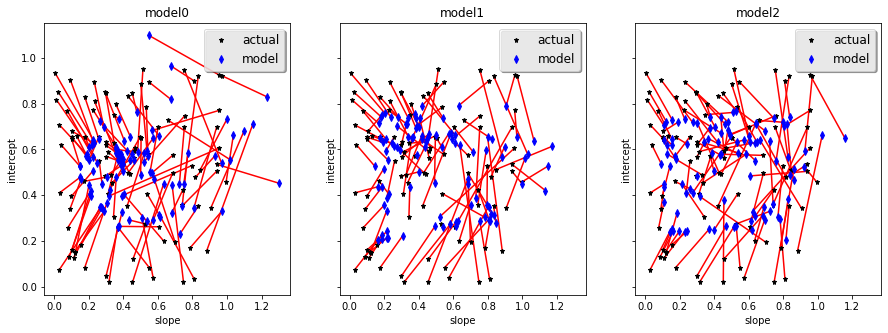

In [39]:
datay, datax, params = generate_dataset_straightline(100)  

fig, axes = plt.subplots( 1, 3, figsize=(15,5), sharex=True, sharey=True)
for indx,ax in enumerate(axes):
    plt.sca( ax )
    plot_predict_params( models[indx], datay, params, decimate=1)
    plt.title('model'+str(indx))

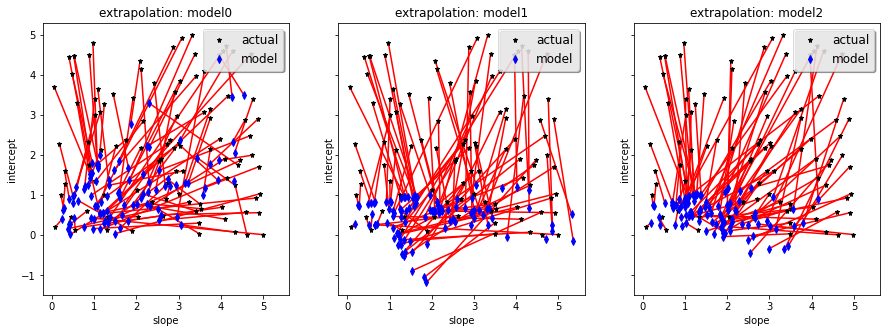

In [40]:
datay, datax, params = generate_dataset_straightline(100, paramlim=[(0,5),(0,5)])  

fig, axes = plt.subplots( 1, 3, figsize=(15,5), sharex=True, sharey=True)
for indx,ax in enumerate(axes):
    plt.sca( ax )
    plot_predict_params( models[indx], datay, params, decimate=1)
    plt.title('extrapolation: model'+str(indx))

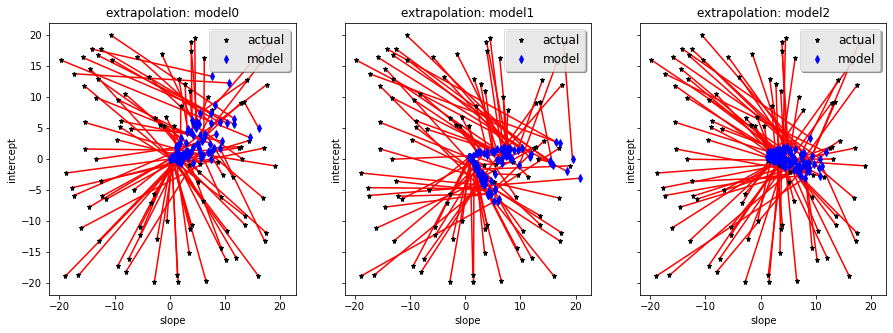

In [41]:
datay, datax, params = generate_dataset_straightline(100, paramlim=[(-20,20),(-20,20)])  

fig, axes = plt.subplots( 1, 3, figsize=(15,5), sharex=True, sharey=True)
for indx,ax in enumerate(axes):
    plt.sca( ax )
    plot_predict_params( models[indx], datay, params, decimate=1)
    plt.title('extrapolation: model'+str(indx))

Analyzing the above plots we can see that changing slope and intercept limits for the data results in the model being unable to determine the slope and intercept correctly, as shown by the increase in discrepancy between the actual slope/intercepts and the model determined slope/intercepts. This highlights the main issue with models trained on specific data, since here it is clear that if the model is given data that does not resemble the data it is used to handling, it fails to correctly determine the nature of the data.

In [49]:
def generate_ideal_dataset_straightline(ncases=1000, x=(-2, -1, 0, +1, +2), paramlim=[(0,1),(0,1)]):
    """ 
    This function generates straight lines with slopes and intercepts within a specified range
    corresponding to datapoints f(-2), f(-1), f(0), f(1) and f(2).
    """
    x = np.array(x, dtype=np.float64)
    nx = len(x) ;# [-2, -1, 0, +1, +2]
    x = np.ones(ncases).reshape(ncases,1) * x.reshape(1,nx)
    
    y = np.zeros( (ncases, nx) ) 
    
    params = np.random.random( (ncases,2) )  # uniform from 0 to 1
    for pindx in [0,1]:
        p = paramlim[pindx]
        p0 = p[0]
        dp = p[1] - p[0]
        params[:,pindx] = params[:,pindx]*dp + p0

    for indx in range(ncases):
        y[indx,0:nx] = x[indx,:]*params[indx,0] + params[indx,1]
    
    return y, x, params 

In [82]:
# Increasing layers
datay, datax, params = generate_ideal_dataset_straightline(9500)

ncases, nsteps = datay.shape

inputs = keras.Input( shape=( nsteps, ), name='input_y' )    

# Feed the result from one layer to the next ie.
# inputs -> dense1 -> dense2 -> outputs
xx = keras.layers.Dense(nsteps, input_dim=nsteps, activation='relu', name='dense1') (inputs)
xx = keras.layers.Dense(nsteps, input_dim=nsteps, activation='relu', name='dense2') (xx)

outputs1= keras.layers.Dense(2, activation=None, name='output_slope_intercept')(xx)
model1 = keras.Model( inputs=inputs, outputs=outputs1, name='Model1')
model1.compile( optimizer='rmsprop', loss='mean_squared_error')
result1 = model1.fit( datay, params, batch_size=64, epochs=40, verbose=0, validation_split=0.3)

xx = keras.layers.Dense(nsteps, input_dim=nsteps, activation='relu', name='dense3') (xx)
outputs2= keras.layers.Dense(2, activation=None, name='output_slope_intercept')(xx)
model2 = keras.Model( inputs=inputs, outputs=outputs2, name='Model2')
model2.compile( optimizer='rmsprop', loss='mean_squared_error')
result2 = model2.fit( datay, params, batch_size=64, epochs=40, verbose=0, validation_split=0.3)

xx = keras.layers.Dense(nsteps, input_dim=nsteps, activation='relu', name='dense4') (xx)
outputs3= keras.layers.Dense(2, activation=None, name='output_slope_intercept')(xx)
model3= keras.Model( inputs=inputs, outputs=outputs3, name='Model3')
model3.compile( optimizer='rmsprop', loss='mean_squared_error')
result3 = model3.fit( datay, params, batch_size=64, epochs=40, verbose=0, validation_split=0.3)

xx = keras.layers.Dense(nsteps, input_dim=nsteps, activation='relu', name='dense5') (xx)
outputs4= keras.layers.Dense(2, activation=None, name='output_slope_intercept')(xx)
model4= keras.Model( inputs=inputs, outputs=outputs4, name='Model4')
model4.compile( optimizer='rmsprop', loss='mean_squared_error')
result4 = model4.fit( datay, params, batch_size=64, epochs=40, verbose=0, validation_split=0.3)

Text(0, 0.5, 'loss')

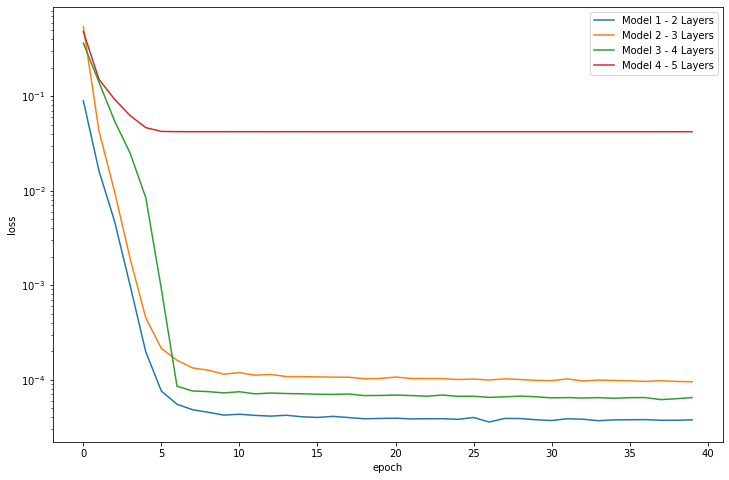

In [83]:
fig, axes = plt.subplots(1, 1, figsize=(12,8))

plt.plot(result1.history['loss'], label = 'Model 1 - 2 Layers')
plt.plot(result2.history['loss'], label = 'Model 2 - 3 Layers')
plt.plot(result3.history['loss'], label = 'Model 3 - 4 Layers')
plt.plot(result4.history['loss'], label = 'Model 4 - 5 Layers')
    
plt.legend(loc=0)
plt.yscale('log') #; plt.xscale('log')
plt.xlabel('epoch') ; plt.ylabel('loss')

In [84]:
# Increasing nodes
datay, datax, params = generate_ideal_dataset_straightline(9500)

ncases, nsteps = datay.shape

inputs = keras.Input( shape=( nsteps, ), name='input_y' )    

# Feed the result from one layer to the next ie.
# inputs -> dense1 -> dense2 -> outputs
results = []
for nodes in [4,6,8,10]:
    xx = keras.layers.Dense(nodes, input_dim=nsteps, activation='relu', name='dense1') (inputs)
    xx = keras.layers.Dense(nodes, input_dim=nsteps, activation='relu', name='dense2') (xx)
    outputs= keras.layers.Dense(2, activation=None, name='output_slope_intercept')(xx)
    model = keras.Model( inputs=inputs, outputs=outputs, name='Model1')
    model.compile( optimizer='rmsprop', loss='mean_squared_error')
    result = model.fit( datay, params, batch_size=64, epochs=40, verbose=0, validation_split=0.3)
    results.append(result)

Text(0, 0.5, 'loss')

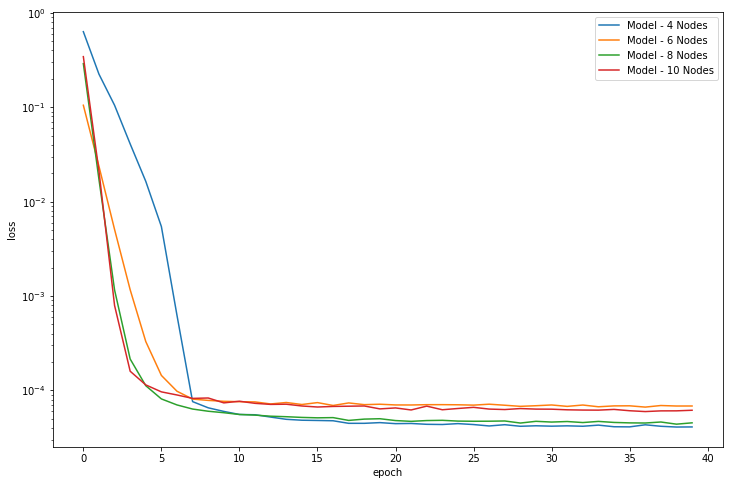

In [85]:
fig, axes = plt.subplots(1, 1, figsize=(12,8))

plt.plot(results[0].history['loss'], label = 'Model - 4 Nodes')
plt.plot(results[1].history['loss'], label = 'Model - 6 Nodes')
plt.plot(results[2].history['loss'], label = 'Model - 8 Nodes')
plt.plot(results[3].history['loss'], label = 'Model - 10 Nodes')
    
plt.legend(loc=0)
plt.yscale('log') #; plt.xscale('log')
plt.xlabel('epoch') ; plt.ylabel('loss')

In [86]:
# Increasing epoch
datay, datax, params = generate_ideal_dataset_straightline(9500)

ncases, nsteps = datay.shape

inputs = keras.Input( shape=( nsteps, ), name='input_y' )    

results = []
for e in [40,60,80,100]:
    # Feed the result from one layer to the next ie.
    # inputs -> dense1 -> dense2 -> outputs
    xx = keras.layers.Dense(nsteps, input_dim=nsteps, activation='relu', name='dense1') (inputs)
    xx = keras.layers.Dense(nsteps, input_dim=nsteps, activation='relu', name='dense2') (xx)
    outputs= keras.layers.Dense(2, activation=None, name='output_slope_intercept')(xx)
    model = keras.Model( inputs=inputs, outputs=outputs, name='Model1')
    model.compile( optimizer='rmsprop', loss='mean_squared_error')
    result = model.fit( datay, params, batch_size=64, epochs=e, verbose=0, validation_split=0.3)
    results.append(result)

Text(0, 0.5, 'loss')

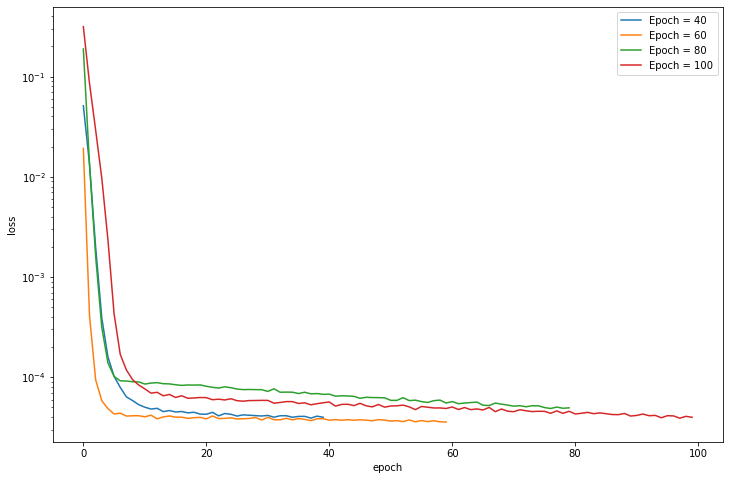

In [87]:
fig, axes = plt.subplots(1, 1, figsize=(12,8))

plt.plot(results[0].history['loss'], label = 'Epoch = 40')
plt.plot(results[1].history['loss'], label = 'Epoch = 60')
plt.plot(results[2].history['loss'], label = 'Epoch = 80')
plt.plot(results[3].history['loss'], label = 'Epoch = 100')
    
plt.legend(loc=0)
plt.yscale('log') #; plt.xscale('log')
plt.xlabel('epoch') ; plt.ylabel('loss')

Analyzing the above 3 plots which explore the variation of 3 separate parameters in our models and the effect on the lossness of the model. The first varies the amount of layers, adding a new layer between each model. In this case the lossness of the models does not indicate that adding more layers increases the models ability to fit the data. In fact, sometimes we notice the opposite effect. Thus we are led to conclude that the amount of layers in the model should be carefully selected for the complexity of the data, more layers in the case of greater complexity. The second varies the amount of nodes used in the model. Here again we do not see a direct correlation between an increase in node number and a decrease in lossness of the model. Again, this indicates that node number should be selected accordingly to the complexity of the data, as the more complex the data the more nodes necessary to fit the data. Thirdly we increase epoch number to verify that increasing the training of the model indeed decreases the lossness, with diminishing returns.